Part 2 – Data Analysis (5.0pt) 
You are kindly asked to work on the big data life cycle.  
2.1. Decide a question you may want to investigate (0.5pt) 
2.2. Collect the data, treat it and prepare a summary statistics analysis. Do not forget to make clear the 
assumptions for the data treatment (1.0pt for data collection and 1.0pt for building the summary) 
2.3. Try to build (at least) simple linear regressions and to explain in the report what (1.0pt) 
2.4. Plot whatever you think is important to highlight to answer your question (see 2.1) (1.0pt) 
2.5. Export the results in a csv file (0.5pt) 

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import gmean, hmean
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
from skopt import BayesSearchCV


# modify file paths
output_dir = r"D:\bigdata"  # this is for storing those output files Example: "C:/Users/YourName/Output"
train = pd.read_csv(r'D:\assignment1 Part2 dataset\train.csv', index_col = 0)#remember to change your path here for train.csv
test = pd.read_csv(r'D:\assignment1 Part2 dataset\test.csv', index_col = 0)#remember to change your path here for test.csv
original = pd.read_csv(r'D:\assignment1 Part2 dataset\credit_risk_dataset.csv')#remember to change your path here for credit_risk_dataset.csv
sub=pd.read_csv(r'D:\assignment1 Part2 dataset\sample_submission.csv')#remember to change your path here for sample_submission.csv
# Merge the data
df = pd.concat([train, original])
print("Data merged successfully!\n")








Data merged successfully!



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


Here, we can observe the dataset size: a total of 91,226 records with 12 features. Regarding missing values, it is evident that "person_emp_length" and "loan_int_rate" have missing data, as the non-NULL counts are less than the total number of records. In terms of data types, this dataset contains not only numerical types but also object types. To better understand the data, I printed the first five rows and used the set function to list the unique values present in the object columns.

In [46]:
# Define output directory and filenames
numerical_stats_file = 'NumericalStatistics_Output.csv'
categorical_stats_file = 'CategoricalStatistics_Output.csv'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Get numerical and categorical features
target = "loan_status"
features = df.drop(target, axis=1).columns.tolist()
categorical_features = df.select_dtypes(include="object").columns.tolist()
numerical_features = list(set(features) - set(categorical_features))

# Calculate descriptive statistics for numerical features
statistics = {}
for col in numerical_features:
    data = df[col].dropna()

    # Basic metrics
    arithmetic_mean = data.mean()

    # Handling Geometric Mean and Harmonic Mean: Filter positive values
    if all(data > 0):
        geometric_mean = gmean(data)
        harmonic_mean = hmean(data)
    else:
        geometric_mean = gmean(data[data > 0]) if any(data > 0) else np.nan  # Compute for positive values only
        harmonic_mean = hmean(data[data > 0]) if any(data > 0) else np.nan  # Compute for positive values only

    median = data.median()
    mode = data.mode().iloc[0] if not data.mode().empty else np.nan

    # Quantiles and variability
    min_val = data.min()
    max_val = data.max()
    range_val = max_val - min_val
    percentile_1 = data.quantile(0.01)
    percentile_50 = data.quantile(0.5)
    percentile_99 = data.quantile(0.99)
    std_dev = data.std(ddof=0)
    variance = data.var(ddof=0)
    coeff_var = std_dev / arithmetic_mean if arithmetic_mean != 0 else np.nan

    # Distribution shape
    skewness = data.skew()
    kurtosis = data.kurt()

    # Store results
    statistics[col] = {
        "Arithmetic Mean": arithmetic_mean,
        "Geometric Mean": geometric_mean,
        "Harmonic Mean": harmonic_mean,
        "Median": median,
        "Mode": mode,
        "Min": min_val,
        "1 pct": percentile_1,
        "50 pct": percentile_50,
        "99 pct": percentile_99,
        "Max": max_val,
        "Range": range_val,
        "Standard Deviation": std_dev,
        "Variance": variance,
        "Coefficient of Variation": coeff_var,
        "Skewness": skewness,
        "Kurtosis": kurtosis,
    }

# Convert numerical statistics to DataFrame and save
numerical_df = pd.DataFrame(statistics).T.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)
numerical_df.to_csv(os.path.join(output_dir, numerical_stats_file), index=True)
print(f"Numerical statistics saved to {os.path.join(output_dir, numerical_stats_file)}")

# Calculate and save descriptive statistics for categorical features
categorical_summary = df[categorical_features].describe(include="O").T
categorical_summary.to_csv(os.path.join(output_dir, categorical_stats_file), index=True)
print(f"Categorical statistics saved to {os.path.join(output_dir, categorical_stats_file)}")

Numerical statistics saved to D:\bigdata/NumericalStatistics_Output.csv
Categorical statistics saved to D:\bigdata/CategoricalStatistics_Output.csv


<ipython-input-46-3e0c394ae820>:69: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numerical_df = pd.DataFrame(statistics).T.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)


In [47]:
print("loan_intent",set(df["loan_intent"]))
print("person_home_ownership",set(df["person_home_ownership"]))
print("loan_grade",set(df["loan_grade"]))
print("cb_person_default_on_file",set(df["cb_person_default_on_file"]))
print("-----------")
target = 'loan_status'
print(df[target].value_counts(normalize=True))

loan_intent {'DEBTCONSOLIDATION', 'VENTURE', 'HOMEIMPROVEMENT', 'MEDICAL', 'EDUCATION', 'PERSONAL'}
person_home_ownership {'RENT', 'MORTGAGE', 'OTHER', 'OWN'}
loan_grade {'D', 'F', 'A', 'G', 'C', 'E', 'B'}
cb_person_default_on_file {'Y', 'N'}
-----------
loan_status
0    0.830553
1    0.169447
Name: proportion, dtype: float64


Since there are object-type features, it is necessary to convert these into numerical types to facilitate subsequent model training and the creation of new features. Here, LabelEncoding is used for encoding. Considering that new features requiring ratios may be built later, and since many features will serve as denominators, I prioritized based on asset wealth and credit score.

Specifically, I manually processed the borrower's housing status to reflect this priority. For the borrower's loan purpose, since there was no clear indication of priority levels, it was automatically encoded by the program. For the borrower's grade, the automatic encoding matched the requirements, so no manual adjustment was needed.

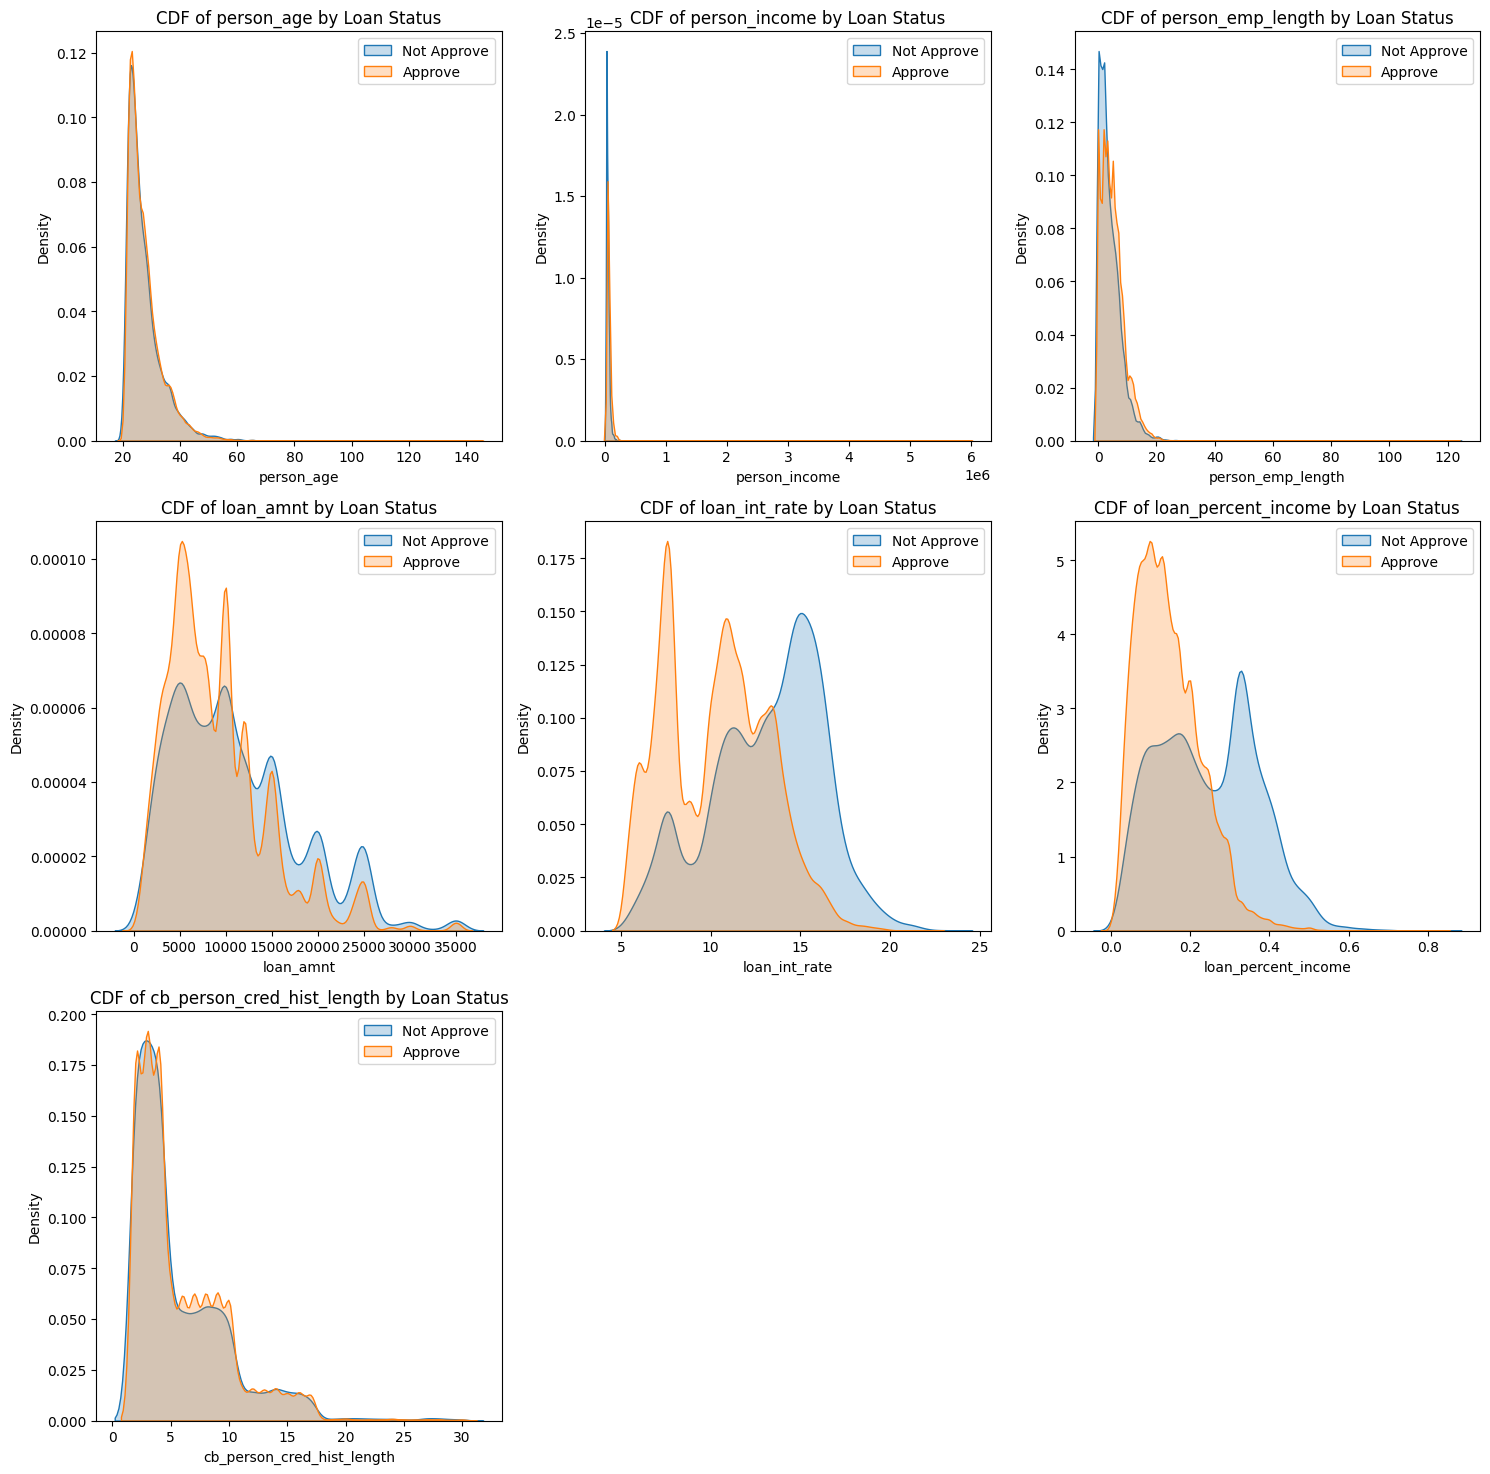

In [64]:


numeric_columns = [col for col in df.select_dtypes(exclude=['object']).columns if col != 'loan_status']

num_cols = 3
num_rows = math.ceil(len(numeric_columns) / num_cols)

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
axs = axs.flatten()

for i, column in enumerate(numeric_columns):
    sns.kdeplot(df[df['loan_status'] == 1][column], label='Not Approve', fill=True, ax=axs[i])
    sns.kdeplot(df[df['loan_status'] == 0][column], label='Approve', fill=True, ax=axs[i])

    axs[i].set_title(f'CDF of {column} by Loan Status')  # 动态设置标题
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Density')
    axs[i].legend()

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

Here u can see the distribution of each features between the loan status

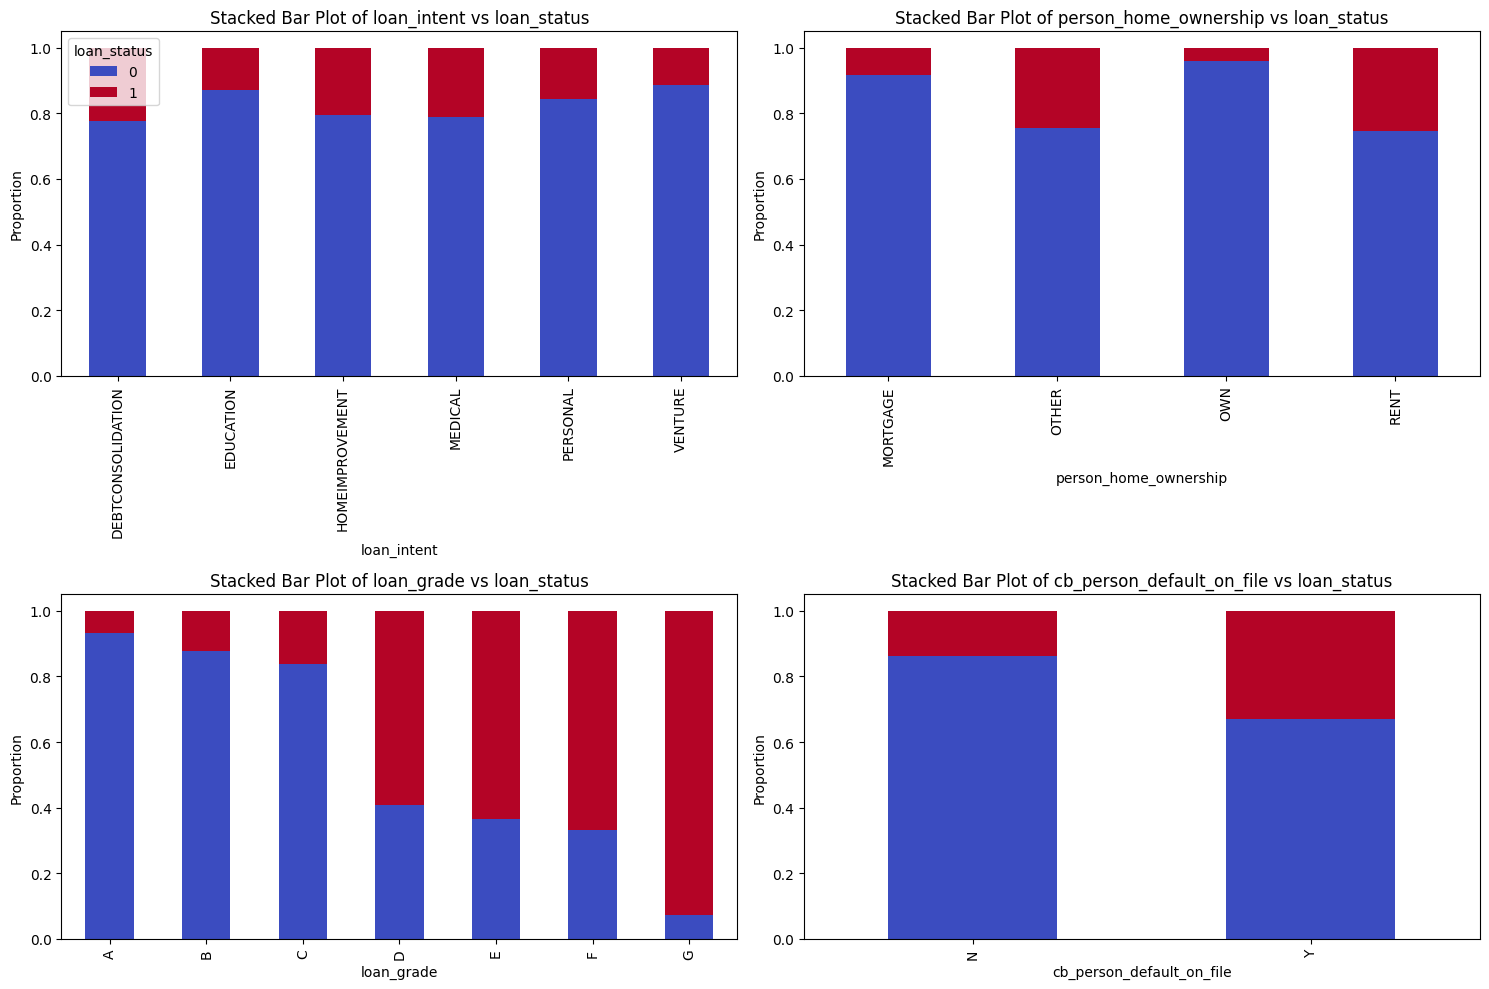

In [49]:
def stacked_bar_subplots(df, features, target='loan_status', nrows=2, ncols=2):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    axs = axs.flatten()

    for i, feature in enumerate(features):
        crosstab = pd.crosstab(df[feature], df[target], normalize='index')
        crosstab.plot(kind='bar', stacked=True, ax=axs[i], cmap='coolwarm', legend=(i == 0))
        axs[i].set_title(f'Stacked Bar Plot of {feature} vs {target}')
        axs[i].set_ylabel('Proportion')
        axs[i].set_xlabel(feature)
    plt.tight_layout()
    plt.show()

features = ['loan_intent', 'person_home_ownership', 'loan_grade', 'cb_person_default_on_file']
stacked_bar_subplots(df, features)

Here u can see the relationship of each object features between the loan status

In [65]:
class CategoryEncoder:
    def __init__(self):
        self.encoding_map = {}
        self.ownership_mapping = {"OWN": 0, "RENT": 1, "MORTGAGE": 2, "OTHER": 3}

    def fit_transform(self, df):
        for column in df.select_dtypes(include=['object']).columns:
            if column == 'person_home_ownership':
                df[column] = df[column].map(self.ownership_mapping)
                self.encoding_map[column] = self.ownership_mapping
            else:
                le = LabelEncoder()
                df[column] = le.fit_transform(df[column])
                self.encoding_map[column] = dict(zip(le.classes_, le.transform(le.classes_)))
        if not self.encoding_map:
            print("Error: encoding_map is empty. Please check if the encoding process succeeded.")

        return df

    def transform(self, df):
        for column, mapping in self.encoding_map.items():
            if column == 'person_home_ownership':
                df[column] = df[column].map(mapping)
            else:
                le = LabelEncoder()
                le.classes_ = list(mapping.keys())
                df[column] = df[column].apply(lambda x: mapping.get(x, -1))

        return df

    def print_encoding_map(self):
        for column, mapping in self.encoding_map.items():
            print(f"\nFeature '{column}' encoding mapping:")
            for original, encoded in mapping.items():
                print(f"  {original} --> {encoded}")

encoder = CategoryEncoder()
df = encoder.fit_transform(df)
encoder.print_encoding_map()
test = encoder.transform(test)
print("\nTransformed Training DataFrame:")
print(df.head())




Feature 'person_home_ownership' encoding mapping:
  OWN --> 0
  RENT --> 1
  MORTGAGE --> 2
  OTHER --> 3

Feature 'loan_intent' encoding mapping:
  DEBTCONSOLIDATION --> 0
  EDUCATION --> 1
  HOMEIMPROVEMENT --> 2
  MEDICAL --> 3
  PERSONAL --> 4
  VENTURE --> 5

Feature 'loan_grade' encoding mapping:
  A --> 0
  B --> 1
  C --> 2
  D --> 3
  E --> 4
  F --> 5
  G --> 6

Feature 'cb_person_default_on_file' encoding mapping:
  N --> 0
  Y --> 1

Transformed Training DataFrame:
   person_age  person_income  person_home_ownership  person_emp_length  \
0          37          35000                      1                0.0   
1          22          56000                      0                6.0   
2          29          28800                      0                8.0   
3          30          70000                      1               14.0   
4          22          60000                      1                2.0   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_incom

Next, I started examining outliers. Here, I calculated the interquartile range (IQR) for the numerical features in the dataset and plotted boxplots for each numerical feature. This provides a clear visualization of the data distribution for each feature.

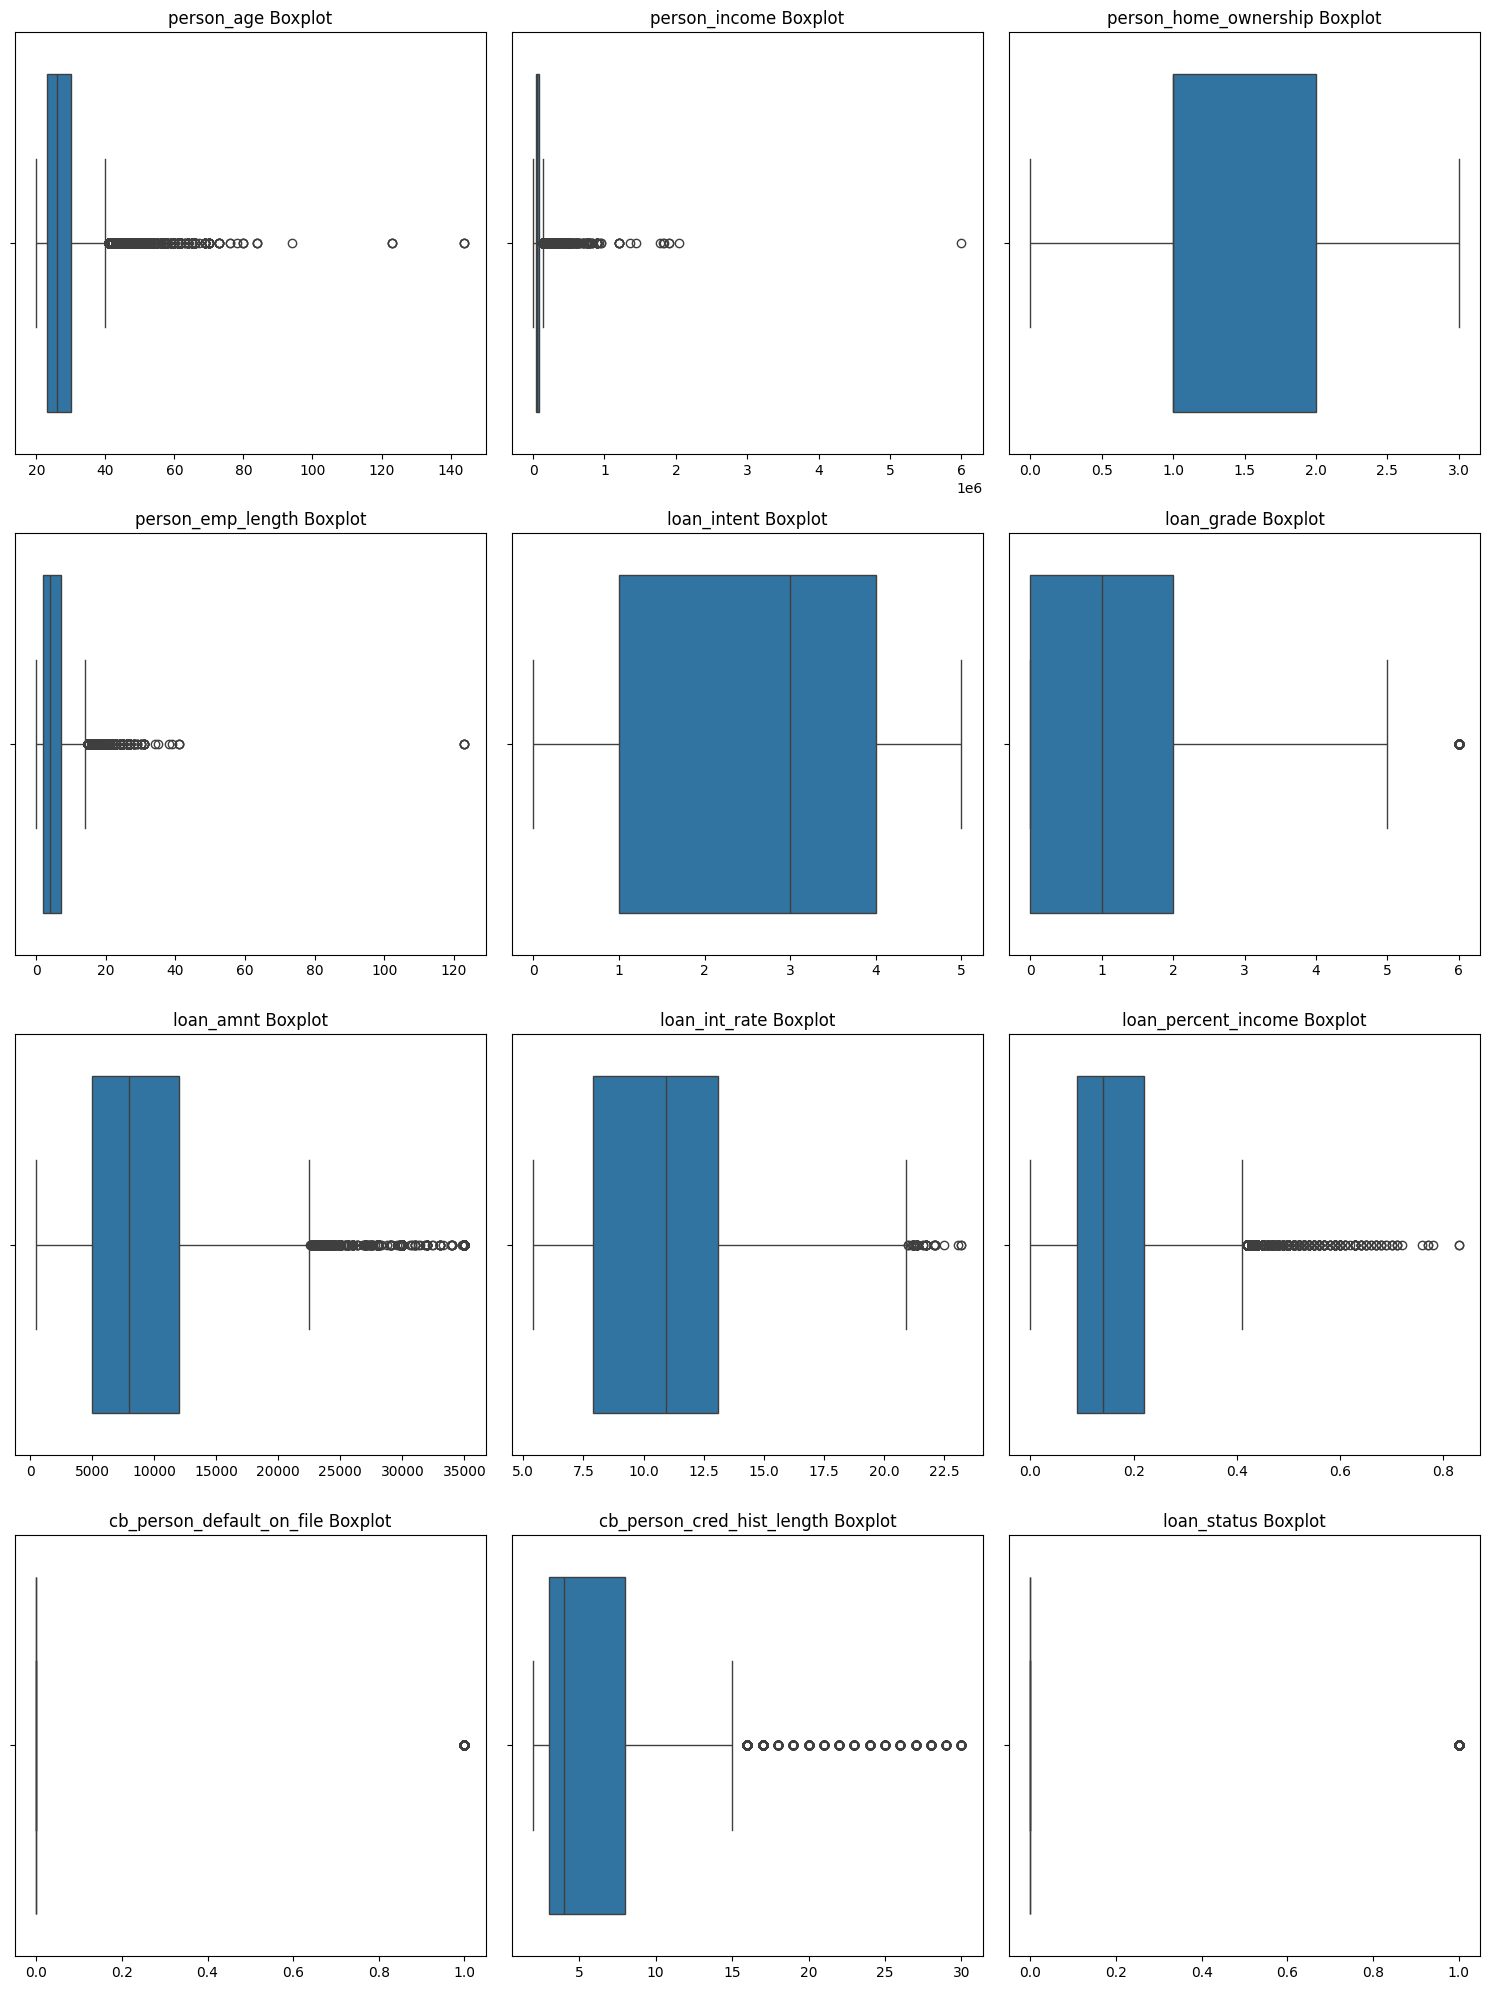

In [61]:
import math
stats_df = pd.DataFrame(index=df.select_dtypes(include=['float64', 'int64']).columns,
                        columns=['Q1', 'Q3', 'IQR'])

num_features = len(df.select_dtypes(include=['float64', 'int64']).columns)

num_cols = 3
num_rows = math.ceil(num_features / num_cols)

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

axs = axs.flatten()

for i, column in enumerate(df.select_dtypes(include=['float64', 'int64']).columns):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    stats_df.loc[column, 'Q1'] = Q1
    stats_df.loc[column, 'Q3'] = Q3
    stats_df.loc[column, 'IQR'] = IQR

    sns.boxplot(x=df[column].values, ax=axs[i])
    axs[i].set_title(f"{column} Boxplot")

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

We initially just used truncation to deal with outliers but finally found that the effect of truncation after removing a very few of the most distant outliers is the best.  So in the end we took that approach to dealing with outliers.  

In [66]:
df = df[~(df["person_age"] > 100)]
df = df[~(df["person_income"] > 2000000)]
df = df[~(df["person_emp_length"] > 100)]
target="loan_status"
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR

    if column != target:
        num_outliers_before = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        print(f"Number of outliers in {column} before clipping: {num_outliers_before}")

        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

        num_outliers_after = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        print(f"Number of outliers in {column} after clipping: {num_outliers_after}")

Number of outliers in person_age before clipping: 1179
Number of outliers in person_age after clipping: 0
Number of outliers in person_income before clipping: 1381
Number of outliers in person_income after clipping: 0
Number of outliers in person_home_ownership before clipping: 0
Number of outliers in person_home_ownership after clipping: 0
Number of outliers in person_emp_length before clipping: 383
Number of outliers in person_emp_length after clipping: 0
Number of outliers in loan_intent before clipping: 0
Number of outliers in loan_intent after clipping: 0
Number of outliers in loan_grade before clipping: 0
Number of outliers in loan_grade after clipping: 0
Number of outliers in loan_amnt before clipping: 602
Number of outliers in loan_amnt after clipping: 0
Number of outliers in loan_int_rate before clipping: 0
Number of outliers in loan_int_rate after clipping: 0
Number of outliers in loan_percent_income before clipping: 129
Number of outliers in loan_percent_income after clippin

The only two columns of missing values in the dataset then begin. After learning and understanding, we chose the KNNimputer method to fill in the missing values. 

In [67]:

imputer = KNNImputer(n_neighbors=5)
df[['person_emp_length', 'loan_int_rate']] = imputer.fit_transform(df[['person_emp_length', 'loan_int_rate']])
print("\nMissing values after imputation:")
print(df[['person_emp_length', 'loan_int_rate']].isna().sum())





Missing values after imputation:
person_emp_length    0
loan_int_rate        0
dtype: int64


In [68]:
def feature_engineering(df):
    # Income situation
    income_60th_percentile = df['person_income'].quantile(0.6)
    income_90th_percentile = df['person_income'].quantile(0.9)

    def assign_income_level_numeric(income):
        if income < income_60th_percentile:
            return 1  # Low income
        elif income < income_90th_percentile:
            return 2  # Middle income
        else:
            return 3  # High income

    df['income_level_numeric'] = df['person_income'].apply(assign_income_level_numeric)
    df['loan_to_income'] = df['loan_amnt'] / df['person_income']
    df['loan_to_income_error'] = (df['loan_amnt'] / df['person_income']) - df['loan_percent_income']
    df['loan_to_income_error'] = df['loan_to_income_error'] * 100
    df['loan_percent_income'] = df['loan_percent_income'] * 100
    df['monthly_income'] = df['person_income'] / 12
    df['person_income'] = np.log(df['person_income'])
    df['monthly_income'] = np.log(df['monthly_income'])

    # Loan history records
    def categorize_past_loans_numeric(n):
        if n < 5:
            return 1  # Less than 5 times
        elif 5 <= n <= 10:
            return 2  # 5-10 times
        else:
            return 3  # More than 10 times

    df['loan_history_category_numeric'] = df['cb_person_cred_hist_length'].apply(categorize_past_loans_numeric)
    df['is_new_credit_user'] = (df['cb_person_cred_hist_length'] < 2).astype(int)

    df['age_to_history'] = df['person_age'] / (df['cb_person_cred_hist_length'] + 1)

    # Credit score
    df['credit_utilization'] = df['loan_amnt'] / df['cb_person_cred_hist_length']
    df['personal_creditscore'] = df['loan_grade'] * df['cb_person_cred_hist_length']
    df['loan_grade_ratio'] = df['loan_amnt'] / (df['loan_grade'] + 1)
    df['cred_hist_to_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']

    # Guarantee and mortgage
    df['loan_home_ownership_ratio'] = df['loan_amnt'] / (df['person_home_ownership'] + 1)

    # Repayment sources and ability
    def assign_employment_stability_numeric(emp_length):
        if emp_length <= 1:
            return 1  # Unstable
        elif emp_length <= 5:
            return 2  # Comparatively stable
        else:
            return 3  # Stable

    df['employment_stability_numeric'] = df['person_emp_length'].apply(assign_employment_stability_numeric)
    df['loan_to_employment'] = df['loan_amnt'] / (df['person_emp_length'] + 1)

    df['age_to_employment'] = df['person_age'] / (df['person_emp_length'] + 1)
    df['employment_to_history'] = df['person_emp_length'] / (df['cb_person_cred_hist_length'] + 1)
    df['stability_score'] = (df['person_emp_length'] * df['person_income']) / (df['loan_amnt'] * (df['cb_person_cred_hist_length'] + 1))

    # Rationality of loan application
    df['intent_loan_ratio'] = df['loan_amnt'] / (df['loan_intent'] + 1)
    df['intent_home_match'] = ((df['loan_intent'] == 'HOMEIMPROVEMENT') & (df['person_home_ownership'] == 'OWN')).astype(int)
    df['income_home_mismatch_rich'] = ((df['person_income'] > df['person_income'].quantile(0.8)) & (df['person_home_ownership'] == 'RENT')).astype(int)
    df['income_home_mismatch_poor'] = ((df['person_income'] < df['person_income'].quantile(0.2)) & (df['person_home_ownership'] == 'OWN')).astype(int)

    # Interest rate risk
    df['credit_rate_ratio'] = df['loan_int_rate'] / df['cb_person_cred_hist_length']
    df['interest_rate_spread'] = df['loan_int_rate'] - df['loan_int_rate'].mean()
    df['high_interest_loan'] = (df['loan_int_rate'] > df['loan_int_rate'].quantile(0.75)).astype(int)

    return df

# Apply feature engineering
df = feature_engineering(df)
test = feature_engineering(test)

# View the data after feature engineering
print("\nTransformed Training DataFrame:")
print(df.head())


Transformed Training DataFrame:
   person_age  person_income  person_home_ownership  person_emp_length  \
0        37.0      10.463103                      1                0.0   
1        22.0      10.933107                      0                6.0   
2        29.0      10.268131                      0                8.0   
3        30.0      11.156251                      1               14.0   
4        22.0      11.002100                      1                2.0   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0            1           1       6000          11.49                 17.0   
1            3           2       4000          13.35                  7.0   
2            4           0       6000           8.90                 21.0   
3            5           1      12000          11.11                 17.0   
4            3           0       6000           6.92                 10.0   

   cb_person_default_on_file  ...  age_to_employment  emplo

Feature Engineering: In this dataset, there are only 11 features, which is far from sufficient for model training. Therefore, it is necessary to expand new features. Since this issue is whether to approve a loan for the borrower, risk considerations must be taken into account. After consulting relevant national materials, I have thought and written new features from seven directions.


In [70]:

features_to_normalize = [col for col in train.columns if col != 'loan_status']
scaler = StandardScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
test[features_to_normalize] = scaler.transform(test[features_to_normalize])

print("Train dataset after standardization:")
print(df.head())

print("\nTest dataset after standardization:")
print(test.head())


Train dataset after standardization:
   person_age  person_income  person_home_ownership  person_emp_length  \
0    1.655504      -0.987453              -0.601354          -1.218066   
1   -0.965743      -0.015848              -2.266983           0.331043   
2    0.257506      -1.390506              -2.266983           0.847412   
3    0.432256       0.445442              -0.601354           2.396521   
4   -0.965743       0.126777              -0.601354          -0.701696   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0    -0.883299   -0.110441  -0.577755       0.227508             0.071538   
1     0.275567    0.804448  -0.925098       0.834922            -0.958918   
2     0.855000   -1.025329  -0.577755      -0.618300             0.483721   
3     1.434433   -0.110441   0.464273       0.103412             0.071538   
4     0.275567   -1.025329  -0.577755      -1.264902            -0.649781   

   cb_person_default_on_file  ...  age_to_employment  e

In [71]:
df.shape

(91215, 36)

Right now is 34 features

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.9163
AdaBoost Training Time: 12.83 seconds
AdaBoost ROC AUC Score: 0.9199
GradientBoosting Accuracy: 0.9378
GradientBoosting Training Time: 32.11 seconds
GradientBoosting ROC AUC Score: 0.9359
[LightGBM] [Info] Number of positive: 10819, number of negative: 53031
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4395
[LightGBM] [Info] Number of data points in the train set: 63850, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169444 -> initscore=-1.589573
[LightGBM] [Info] Start training from score -1.589573
LightGBM Accuracy: 0.9481
LightGBM Training Time: 1.80 seconds
LightGBM ROC AUC Score: 0.9567


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:47:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9473
XGBoost Training Time: 2.51 seconds
XGBoost ROC AUC Score: 0.9542
RandomForest Accuracy: 0.9423
RandomForest Training Time: 20.12 seconds
RandomForest ROC AUC Score: 0.9344
BaggingClassifier Accuracy: 0.9450
BaggingClassifier Training Time: 140.56 seconds
BaggingClassifier ROC AUC Score: 0.9383
BaggingClassifier does not support feature importance extraction.
CatBoost Accuracy: 0.9475
CatBoost Training Time: 2.50 seconds
CatBoost ROC AUC Score: 0.9522


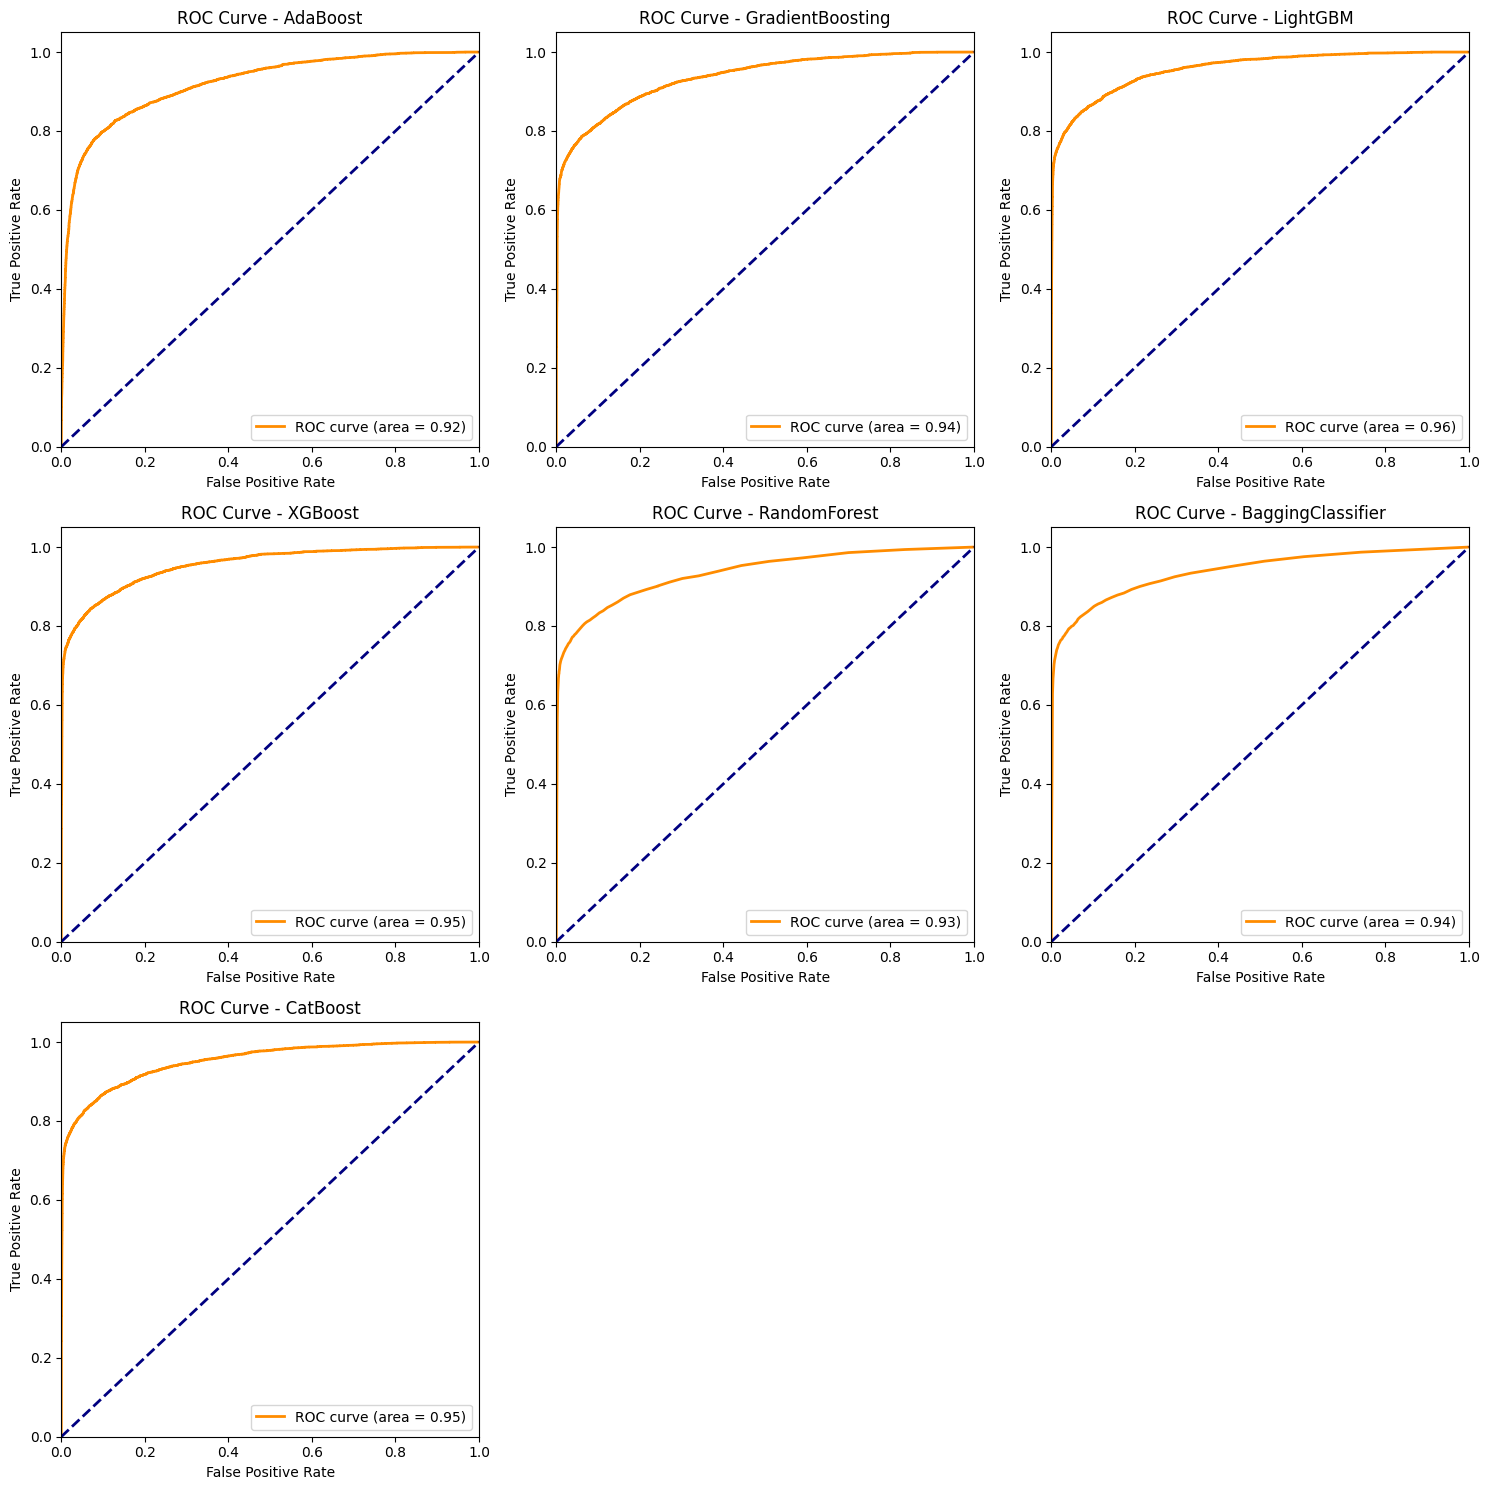

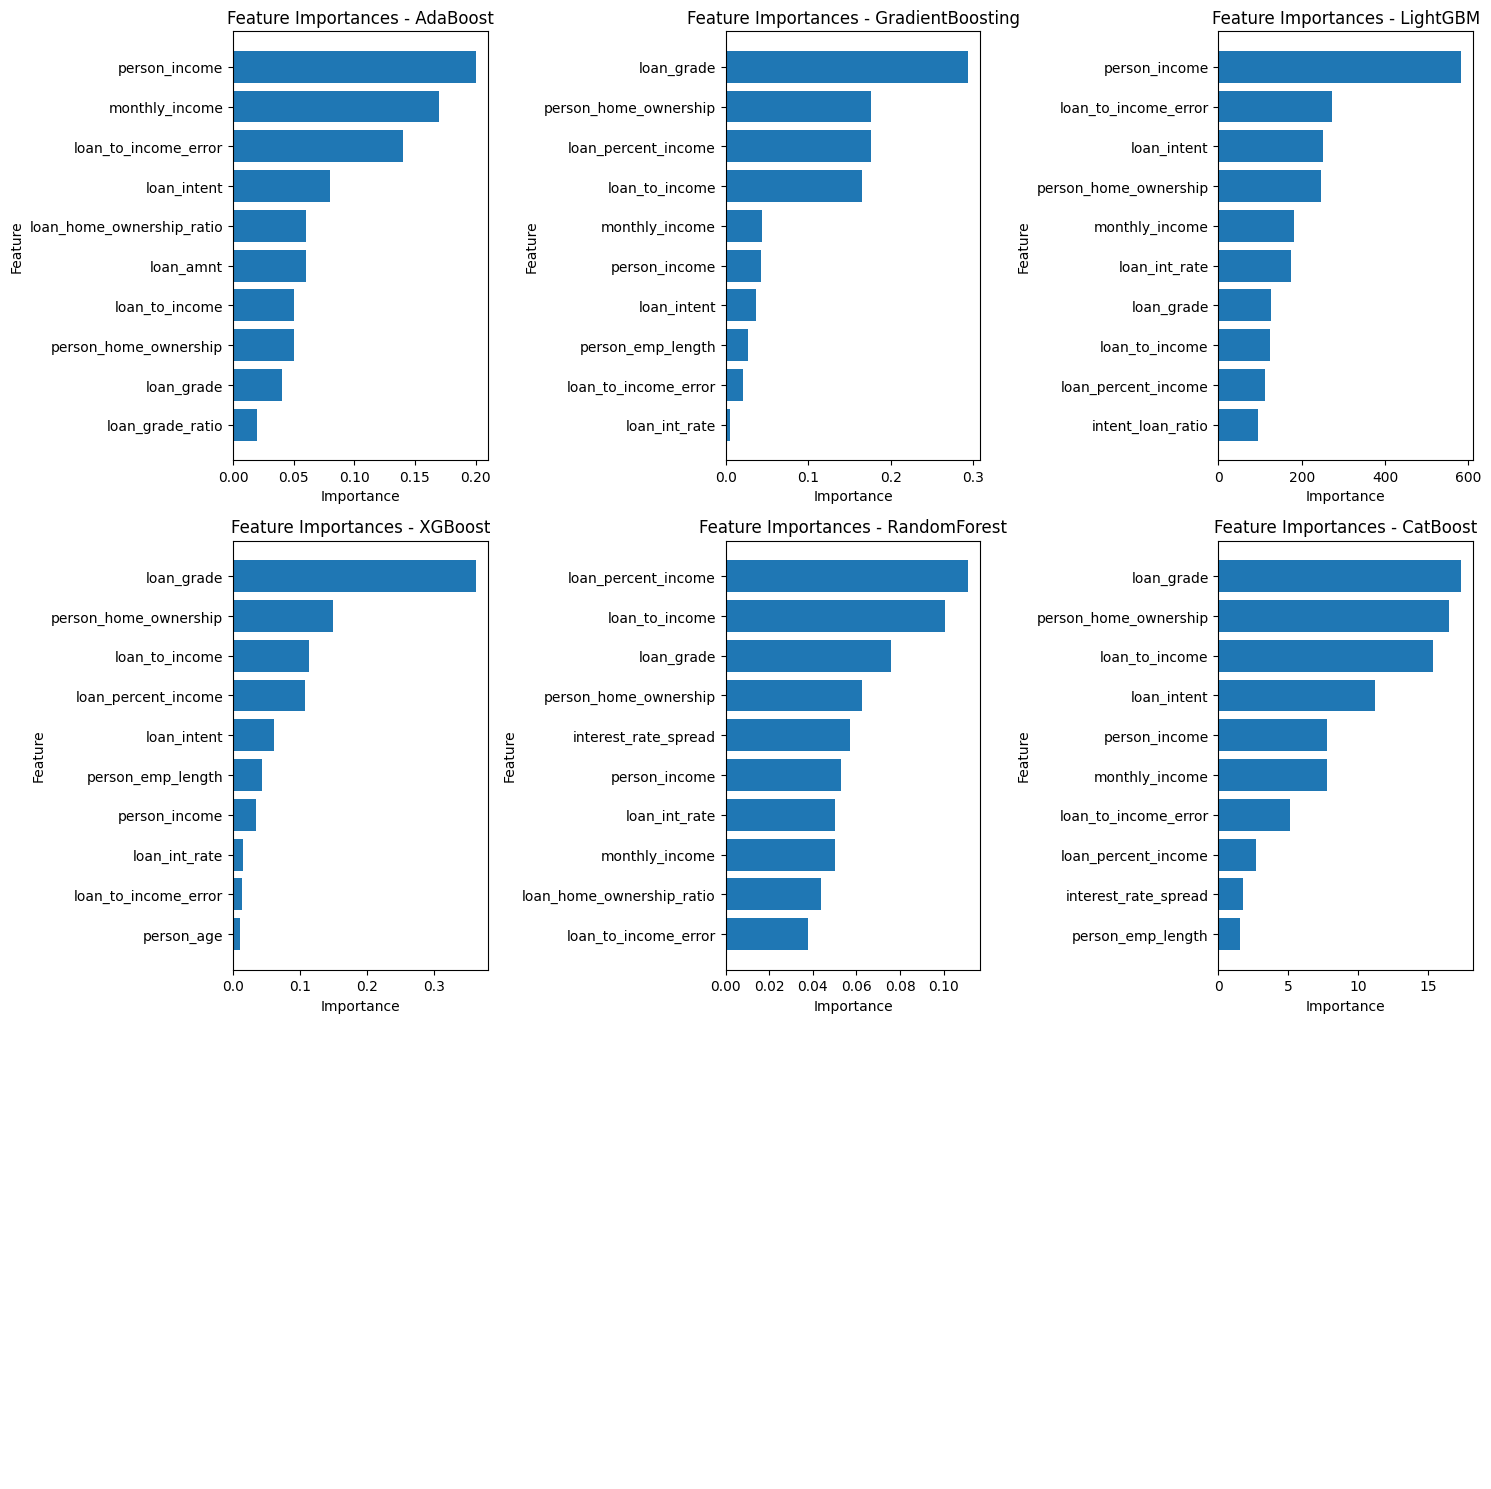

In [ ]:
# Split the data into features and target
X = df.drop(columns=target)
y = df[target]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):

    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Training Time: {training_time:.2f} seconds")

    roc_auc = None
    fpr = None
    tpr = None

    # Calculate the ROC AUC score
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        print(f"{model_name} ROC AUC Score: {roc_auc:.4f}")
    else:
        print(f"{model_name} does not support probability prediction, skipping ROC AUC.")

    # Get feature importance
    feature_importances = None
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    else:
        print(f"{model_name} does not support feature importance extraction.")

    return {
        'model_name': model_name,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'feature_importances': feature_importances
    }


# Define the models to evaluate
models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "BaggingClassifier": BaggingClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(n_estimators=100, verbose=0, random_state=42)
}

# List to store evaluation results
results = []

# Dictionary to store feature importances
feature_importances = {}

# Train and evaluate each model
for model_name, model in models.items():
    result = evaluate_model(model, X_train, X_test, y_train, y_test, model_name=model_name)
    results.append(result)
    # Store feature importance
    if result['feature_importances'] is not None:
        feature_importances[model_name] = pd.Series(
            result['feature_importances'],
            index=X_train.columns
        ).sort_values(ascending=False)

# Plot ROC curves
fig_roc, axes_roc = plt.subplots(3, 3, figsize=(15, 15))
axes_roc = axes_roc.flatten()

for i, result in enumerate(results):
    ax = axes_roc[i]
    if result['fpr'] is not None:
        ax.plot(result['fpr'], result['tpr'], color='darkorange', lw=2,
                label=f'ROC curve (area = {result["roc_auc"]:.2f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {result["model_name"]}')
        ax.legend(loc='lower right')
    else:
        ax.axis('off')

for j in range(len(results), len(axes_roc)):
    axes_roc[j].axis('off')

plt.tight_layout()
plt.show()

# Plot feature importance
fig_fi, axes_fi = plt.subplots(3, 3, figsize=(15, 15))
axes_fi = axes_fi.flatten()

for i, (model_name, importances) in enumerate(feature_importances.items()):
    ax = axes_fi[i]
    top_importances = importances.head(10)
    ax.barh(top_importances.index[::-1], top_importances.values[::-1])
    ax.set_title(f'Feature Importances - {model_name}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')

for j in range(len(feature_importances), len(axes_fi)):
    axes_fi[j].axis('off')

plt.tight_layout()
plt.show()

# Save feature importances to a CSV file
importance_df = pd.DataFrame(feature_importances)
importance_df.fillna(0, inplace=True)
importance_df['Mean_Importance'] = importance_df.mean(axis=1)
importance_df.sort_values(by='Mean_Importance', ascending=False, inplace=True)
importance_df.to_csv("features.csv")


Here I try different model to find the best ones.And accoring to the result, lightgbm\xgboost and catboost are the top 3. finally I print the features importance in the excel file to check which features contribute most so that I can remove some of them in the 34 features

Streaming output truncated to the last 5000 lines.
[20]	valid_0's binary_logloss: 0.23909
[25]	valid_0's binary_logloss: 0.222037
[30]	valid_0's binary_logloss: 0.20945
[35]	valid_0's binary_logloss: 0.200163
[40]	valid_0's binary_logloss: 0.192788
[45]	valid_0's binary_logloss: 0.18696
[50]	valid_0's binary_logloss: 0.182898
[55]	valid_0's binary_logloss: 0.179585
[60]	valid_0's binary_logloss: 0.177353
[65]	valid_0's binary_logloss: 0.175672
[70]	valid_0's binary_logloss: 0.173992
[75]	valid_0's binary_logloss: 0.172529
[80]	valid_0's binary_logloss: 0.171603
[85]	valid_0's binary_logloss: 0.170614
[90]	valid_0's binary_logloss: 0.170251
[95]	valid_0's binary_logloss: 0.169607
[100]	valid_0's binary_logloss: 0.168995
[105]	valid_0's binary_logloss: 0.168775
Did not meet early stopping. Best iteration is:
[104]	valid_0's binary_logloss: 0.168735
[LightGBM] [Info] Number of positive: 6491, number of negative: 31819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:04:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:04:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:04:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:04:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:04:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 5410, number of negative: 26515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4350
[LightGBM] [Info] Number of data points in the train set: 31925, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169460 -> initscore=-1.589462
[LightGBM] [Info] Start training from score -1.589462


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:17:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3607, number of negative: 17676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 21283, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169478 -> initscore=-1.589331
[LightGBM] [Info] Start training from score -1.589331
[LightGBM] [Info] Number of positive: 3606, number of negative: 17677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4324
[LightGBM] [Info] Number of data points in the train set: 21283, number of used features: 26
[LightGBM] [Info] [b

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:17:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:17:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:17:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 5409, number of negative: 26516
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4349
[LightGBM] [Info] Number of data points in the train set: 31925, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169428 -> initscore=-1.589684
[LightGBM] [Info] Start training from score -1.589684


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:18:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3606, number of negative: 17677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4316
[LightGBM] [Info] Number of data points in the train set: 21283, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169431 -> initscore=-1.589665
[LightGBM] [Info] Start training from score -1.589665
[LightGBM] [Info] Number of positive: 3606, number of negative: 17677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4342
[LightGBM] [Info] Number of data points in the train set: 21283, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169431 -> initscore=-1.589665
[Lig

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:18:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:18:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:18:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimized Stacking Classifier CV ROC AUC scores: [0.95175776 0.95179215]
Mean CV ROC AUC score: 0.95177495282792
[LightGBM] [Info] Number of positive: 10819, number of negative: 53031
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4381
[LightGBM] [Info] Number of data points in the train set: 63850, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169444 -> initscore=-1.589573
[LightGBM] [Info] Start training from score -1.589573


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:18:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 7212, number of negative: 35354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4366
[LightGBM] [Info] Number of data points in the train set: 42566, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169431 -> initscore=-1.589665
[LightGBM] [Info] Start training from score -1.589665
[LightGBM] [Info] Number of positive: 7213, number of negative: 35354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4359
[LightGBM] [Info] Number of data points in the train set: 42567, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169451 -> initscore=-1.589527
[Lig

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:18:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:19:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:19:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Stacked Model Test ROC AUC Score: 0.9581


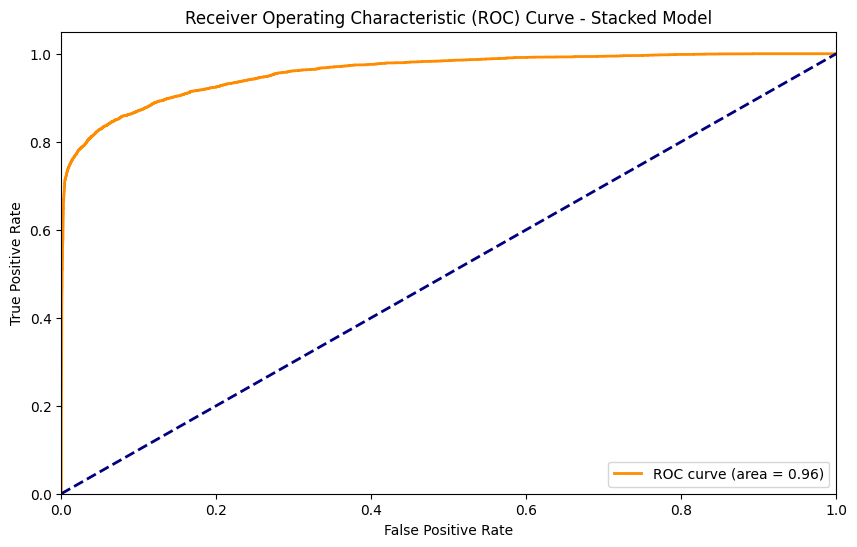

      id  loan_status
0  58645     0.987434
1  58646     0.032497
2  58647     0.738043
3  58648     0.028079
4  58649     0.049864


In [ ]:


# Data separation (based on the selected features and target variable)
selected_features = [
    'person_income', 'loan_to_income_error', 'person_home_ownership', 'loan_intent',
    'loan_int_rate', 'loan_grade', 'loan_percent_income', 'loan_to_income',
    'person_age', 'loan_home_ownership_ratio', 'intent_loan_ratio', 'loan_to_employment',
    'credit_rate_ratio', 'loan_grade_ratio', 'stability_score', 'person_emp_length',
    'age_to_employment', 'credit_utilization', 'employment_to_history', 'personal_creditscore',
    'loan_amnt', 'age_to_history', 'interest_rate_spread', 'cred_hist_to_age_ratio',
    'cb_person_cred_hist_length','monthly_income']


# Separate features and target variable
X = df[selected_features]
y = df[target]

# Split the data into training set, validation set, and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)  # 0.25 x 0.7 = 0.175

# Define the parameter search space for Bayesian optimization
param_grid_lgb = {
    'n_estimators': (100, 500),
    'learning_rate': (0.01, 0.05, 'log-uniform'),
    'num_leaves': (31, 200),
    'max_depth': (5, 15)
}

param_grid_xgb = {
    'n_estimators': (100, 500),
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'max_depth': (3, 10)
}

param_grid_cat = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7]
}
# Bayesian optimization for base models
# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_search = BayesSearchCV(
    lgb_model,
    param_grid_lgb,
    n_iter=30,
    cv=5,  # Changed to 5-fold cross-validation
    scoring='roc_auc',
    random_state=42
)
lgb_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=5)])
optimized_lgb = lgb_search.best_estimator_

# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_search = BayesSearchCV(
    xgb_model,
    param_grid_xgb,
    n_iter=30,
    cv=5,  # Changed to 5-fold cross-validation
    scoring='roc_auc',
    random_state=42
)
xgb_search.fit(X_train, y_train)
optimized_xgb = xgb_search.best_estimator_
# CatBoost
cat = CatBoostClassifier(silent=True, random_state=42)
cat_search = GridSearchCV(cat, param_grid=param_grid_cat, scoring='roc_auc', cv=3)
cat_search.fit(X_train, y_train)
optimized_cat = cat_search.best_estimator_
# Build a stacking model using the optimized base models
stacking_clf = StackingClassifier(estimators=[
        ('lgb', optimized_lgb),('xgb',optimized_xgb),('cat', optimized_cat)],final_estimator=LogisticRegression(),cv=3 )

# Evaluate the performance of the stacking model using 2-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=2)
cv_scores = cross_val_score(stacking_clf, X_train_full, y_train_full, cv=stratified_cv, scoring='roc_auc')
print("Optimized Stacking Classifier CV ROC AUC scores:", cv_scores)
print("Mean CV ROC AUC score:", cv_scores.mean())

# Final evaluation on the test set
stacking_clf.fit(X_train_full, y_train_full)
y_test_pred = stacking_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print(f"Stacked Model Test ROC AUC Score: {roc_auc:.4f}")

# Plot the ROC curve for the test set
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Stacked Model')
plt.legend(loc='lower right')
plt.show()
sub_test = test[selected_features]
# Make predictions on the test.csv provided by Kaggle
y_predict_test = stacking_clf.predict(sub_test)
y_pred_proba = stacking_clf.predict_proba(sub_test)[:, 1]  # Extract the predicted probability scores

#print final result
sub['loan_status'] = y_pred_proba
print(sub.head())
sub.to_csv("prediction result.csv", index=False)

SO here I combine the three models together to predict the result. and I use BayesSearchCV to search the parameters automatically to find the best parameters for each model

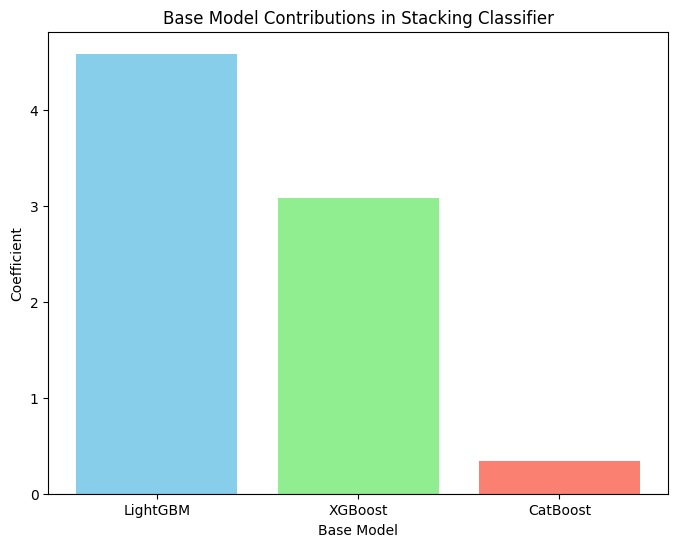

  Base Model  Coefficient
0   LightGBM     4.585470
1    XGBoost     3.084504
2   CatBoost     0.339294


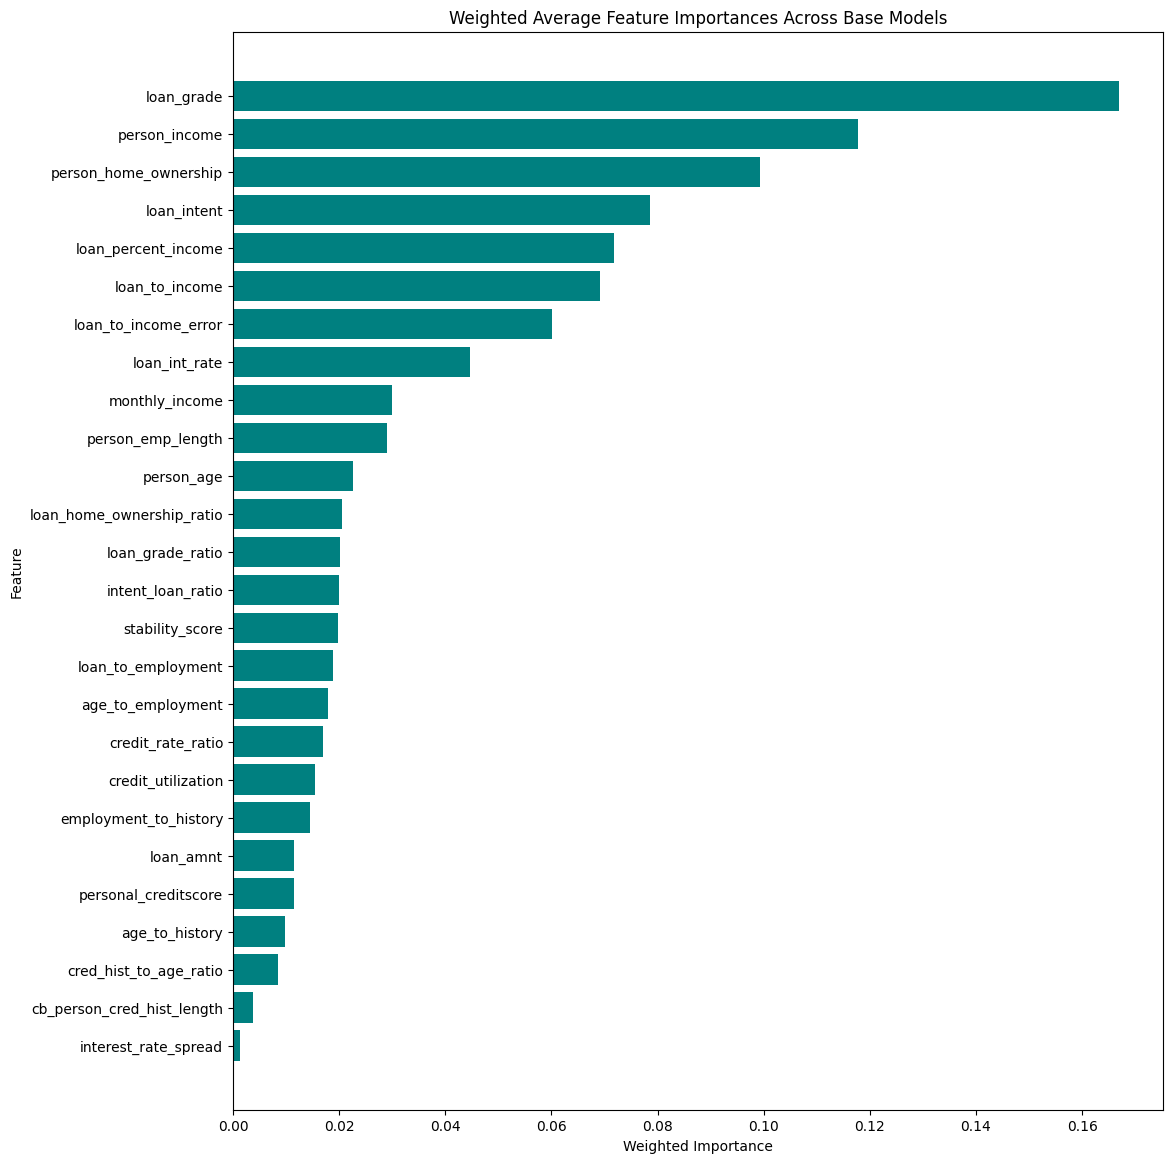

                  Feature  Weighted_Importance
5              loan_grade             0.166901
0           person_income             0.117725
2   person_home_ownership             0.099231
3             loan_intent             0.078545
6     loan_percent_income             0.071847
7          loan_to_income             0.069148
1    loan_to_income_error             0.060077
4           loan_int_rate             0.044584
25         monthly_income             0.029872
15      person_emp_length             0.028938


In [76]:
# Extract LightGBM feature importance
lgb_importances = optimized_lgb.feature_importances_
lgb_features = X_train.columns
lgb_feat_imp_df = pd.DataFrame({'Feature': lgb_features, 'Importance': lgb_importances})
lgb_feat_imp_df = lgb_feat_imp_df.sort_values(by='Importance', ascending=False)

# Extract XGBoost feature importance
xgb_importances = optimized_xgb.feature_importances_
xgb_features = X_train.columns
xgb_feat_imp_df = pd.DataFrame({'Feature': xgb_features, 'Importance': xgb_importances})
xgb_feat_imp_df = xgb_feat_imp_df.sort_values(by='Importance', ascending=False)

# Extract CatBoost feature importance
cat_importances = optimized_cat.get_feature_importance()
cat_features = X_train.columns
cat_feat_imp_df = pd.DataFrame({'Feature': cat_features, 'Importance': cat_importances})
cat_feat_imp_df = cat_feat_imp_df.sort_values(by='Importance', ascending=False)

# Retrieve coefficients of the final classifier in stacking
model_contributions = stacking_clf.final_estimator_.coef_[0]
base_models = ['LightGBM', 'XGBoost', 'CatBoost']
model_contrib_df = pd.DataFrame({'Base Model': base_models, 'Coefficient': model_contributions})

# Plot base model contributions in the stacking classifier
plt.figure(figsize=(8, 6))
plt.bar(model_contrib_df['Base Model'], model_contrib_df['Coefficient'], color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Base Model Contributions in Stacking Classifier')
plt.xlabel('Base Model')
plt.ylabel('Coefficient')
plt.axhline(0, color='grey', linewidth=0.8)
plt.show()
print(model_contrib_df)

# Normalize feature importance for each base model
lgb_feat_imp_df['Normalized_Importance'] = lgb_feat_imp_df['Importance'] / lgb_feat_imp_df['Importance'].sum()
xgb_feat_imp_df['Normalized_Importance'] = xgb_feat_imp_df['Importance'] / xgb_feat_imp_df['Importance'].sum()
cat_feat_imp_df['Normalized_Importance'] = cat_feat_imp_df['Importance'] / cat_feat_imp_df['Importance'].sum()

# Normalize contributions of each base model
model_contrib_df['Abs_Coefficient'] = model_contrib_df['Coefficient'].abs()
model_contrib_df['Normalized_Coefficient'] = model_contrib_df['Abs_Coefficient'] / model_contrib_df['Abs_Coefficient'].sum()

# Create a dictionary to map base models and their weights
model_weight = model_contrib_df.set_index('Base Model')['Normalized_Coefficient'].to_dict()

# Combine feature importance
merged_feat_imp = pd.DataFrame()
merged_feat_imp['Feature'] = lgb_feat_imp_df['Feature']
merged_feat_imp['LightGBM'] = lgb_feat_imp_df['Normalized_Importance']
merged_feat_imp['XGBoost'] = xgb_feat_imp_df['Normalized_Importance']
merged_feat_imp['CatBoost'] = cat_feat_imp_df['Normalized_Importance']

# Calculate weighted average feature importance
merged_feat_imp['Weighted_Importance'] = (
    merged_feat_imp['LightGBM'] * model_weight['LightGBM'] +
    merged_feat_imp['XGBoost'] * model_weight['XGBoost'] +
    merged_feat_imp['CatBoost'] * model_weight['CatBoost']
)

merged_feat_imp = merged_feat_imp.sort_values(by='Weighted_Importance', ascending=False)

# Plot weighted average feature importances across base models
plt.figure(figsize=(12, 14))
plt.barh(merged_feat_imp['Feature'], merged_feat_imp['Weighted_Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title('Weighted Average Feature Importances Across Base Models')
plt.xlabel('Weighted Importance')
plt.ylabel('Feature')
plt.show()

# Print the top 10 important features
print(merged_feat_imp[['Feature', 'Weighted_Importance']].head(10))
